In [10]:
from google.colab import drive
drive.mount('/content/drive')
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'big data'/  'boss gt1'/   CNN.ipynb   CV.pdf  'pc blanco'/  'PFC 1'/  'Trepanador '/


In [11]:
%cd /content/drive/MyDrive/
%ls

/content/drive/MyDrive
'big data'/  'boss gt1'/   CNN.ipynb   CV.pdf  'pc blanco'/  'PFC 1'/  'Trepanador '/


In [12]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub
import zipfile
import shutil

# Configurar el estilo de las gráficas
plt.style.use('seaborn-v0_8')
sns.set_theme()
sns.set_palette("husl")

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [13]:
# Función para configurar el dataset
def setup_dataset():
    """Descargar y preparar el dataset"""
    print("📥 Descargando el dataset de melanoma...")

    # Descargar el dataset
    dataset_path = kagglehub.dataset_download("drscarlat/melanoma")
    print(f"Dataset descargado en: {dataset_path}")

    # Examinar la estructura actual
    print("\n📁 Explorando archivos descargados:")
    base_dir = dataset_path
    print(f"Directorio base: {base_dir}")

    # Listar contenido
    print("\nContenido del directorio:")
    for root, dirs, files in os.walk(base_dir):
        level = root.replace(base_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f"{subindent}{f}")

    # Si el dataset ya está en la estructura correcta, usar esa ruta
    if os.path.exists(os.path.join(base_dir, 'train_sep')):
        print("\n✅ Estructura del dataset encontrada correctamente")
        return base_dir

    # Si no está en la estructura correcta, buscar los directorios necesarios
    dermmel_dirs = []
    for root, dirs, files in os.walk(base_dir):
        if 'train_sep' in dirs or 'valid' in dirs or 'test' in dirs:
            dermmel_dirs.append(root)

    if dermmel_dirs:
        print("\n✅ Directorio del dataset encontrado")
        return dermmel_dirs[0]

    print("\n❌ No se encontró la estructura esperada del dataset")
    raise FileNotFoundError("No se encontró la estructura esperada del dataset")


In [14]:
# Función para cargar y preparar los datos
def load_and_prepare_data(base_dir, img_height=224, img_width=224, batch_size=32):
    print("🔄 Cargando y preparando datos...")

    # rutas
    train_dir = os.path.join(base_dir, 'train_sep')
    valid_dir = os.path.join(base_dir, 'valid')
    test_dir = os.path.join(base_dir, 'test')

    # Crear ImageDataGenerator para normalización
    data_generator = ImageDataGenerator(rescale=1./255)

    # Cargar datos de entrenamiento
    train_data = data_generator.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    # Cargar datos de validación
    valid_data = data_generator.flow_from_directory(
        valid_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    # Cargar datos de prueba
    test_data = data_generator.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    # Mostrar información sobre los datos
    print("\n📊 Resumen de los datos:")
    print(f"Muestras de entrenamiento: {train_data.samples}")
    print(f"Muestras de validación: {valid_data.samples}")
    print(f"Muestras de prueba: {test_data.samples}")
    print(f"Clases: {train_data.class_indices}")

    return train_data, valid_data, test_data

In [15]:
# Definición de modelos
def create_model_1(input_shape, activation='relu', kernel_initializer='he_normal'):
    """Modelo básico con capas densas"""
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(128, activation=activation, kernel_initializer=kernel_initializer),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation=activation, kernel_initializer=kernel_initializer),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_model_2(input_shape, activation='relu', kernel_initializer='he_normal'):
    """Modelo CNN simple"""
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activation),
        layers.Flatten(),
        layers.Dense(64, activation=activation),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_model_3(input_shape, activation='relu', kernel_initializer='he_normal'):
    """Modelo CNN más profundo con regularización"""
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation=activation, kernel_initializer=kernel_initializer),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activation),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation=activation),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(64, activation=activation),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

print("✅ Modelos definidos correctamente")

✅ Modelos definidos correctamente


In [16]:
# Funciones de entrenamiento y evaluación
def train_and_evaluate(model, train_data, valid_data, epochs=50, model_name="model"):
    # Callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )

    # Compilar modelo
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    # Mostrar resumen del modelo
    print(f"\n🏗️ Arquitectura del modelo {model_name}:")
    model.summary()

    # Entrenar modelo
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=valid_data,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    return history

In [17]:
# Funciones de visualización
def plot_training_metrics(history, model_name):
    """Graficar métricas de entrenamiento"""
    metrics = ['loss', 'accuracy', 'auc']
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f'Métricas de Entrenamiento - {model_name}', fontsize=16)

    for idx, metric in enumerate(metrics):
        axes[idx].plot(history.history[metric], label=f'Training {metric}')
        axes[idx].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        axes[idx].set_title(f'{metric.capitalize()} vs. Epochs')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].legend()

    plt.tight_layout()
    plt.show()

def evaluate_model_performance(model, test_data, model_name):
    """Evaluar y visualizar el rendimiento del modelo"""
    # Evaluar modelo
    test_loss, test_acc, test_auc = model.evaluate(test_data)

    # Obtener predicciones
    predictions = model.predict(test_data)
    y_pred = (predictions > 0.5).astype(int)
    y_true = test_data.labels

    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_true, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Imprimir reporte de clasificación
    print(f"\n📊 Reporte de Clasificación - {model_name}:")
    print(classification_report(y_true, y_pred))

    return test_acc, test_auc

In [18]:
# Función de experimentación
def run_experiments(base_dir, img_height=224, img_width=224):
    # Cargar datos
    train_data, valid_data, test_data = load_and_prepare_data(base_dir, img_height, img_width)

    # Configuraciones a probar
    configurations = [
        {
            'name': 'Model1_Dense_ReLU',
            'model_fn': create_model_1,
            'activation': 'relu',
            'initializer': 'he_normal'
        },
        {
            'name': 'Model2_CNN_LeakyReLU',
            'model_fn': create_model_2,
            'activation': tf.keras.layers.LeakyReLU(alpha=0.1),
            'initializer': 'he_normal'
        },
        {
            'name': 'Model3_DeepCNN_ReLU',
            'model_fn': create_model_3,
            'activation': 'relu',
            'initializer': 'glorot_uniform'
        }
    ]

    results = {}
    for config in configurations:
        print(f"\n🚀 Entrenando {config['name']}...")

        model = config['model_fn'](
            (img_height, img_width, 3),
            activation=config['activation'],
            kernel_initializer=config['initializer']
        )

        # Entrenar modelo
        history = train_and_evaluate(
            model, train_data, valid_data,
            model_name=config['name']
        )

        # Visualizar resultados
        plot_training_metrics(history, config['name'])
        test_acc, test_auc = evaluate_model_performance(
            model, test_data, config['name']
        )

        # Guardar resultados
        results[config['name']] = {
            'model': model,
            'history': history,
            'test_accuracy': test_acc,
            'test_auc': test_auc
        }

    return results


🎯 Iniciando experimentos de clasificación de melanoma...
📥 Descargando el dataset de melanoma...


100%|██████████| 5.26G/5.26G [00:54<00:00, 105MB/s]

Extracting files...


Se truncaron las últimas líneas 5000 del resultado de transmisión.
                AUG_0_3028.jpeg
                AUG_0_619.jpeg
                AUG_0_6302.jpeg
                AUG_0_5907.jpeg
                AUG_0_2168.jpeg
                AUG_0_661.jpeg
                AUG_0_2750.jpeg
                ISIC_0028288.jpg
                AUG_0_2310.jpeg
                ISIC_0027552.jpg
                AUG_0_2471.jpeg
                AUG_0_1490.jpeg
                AUG_0_3892.jpeg
                ISIC_0032535.jpg
                ISIC_0026993.jpg
                AUG_0_6755.jpeg
                AUG_0_4519.jpeg
                ISIC_0027863.jpg
                AUG_0_3001.jpeg
                AUG_0_7428.jpeg
                AUG_0_571.jpeg
                ISIC_0028860.jpg
                AUG_0_7312.jpeg
                AUG_0_1887.jpeg
                AUG_0_3972.jpeg
                AUGmented_0_7580.jpeg
                AUG_0_4091.jpeg
                AUG_0_1972.jpeg
                AUG_0_4572.j

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      19,267,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,276,801 (73.54 MB)

 Trainable params: 19,276,417 (73.53 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 74s 202ms/step - accuracy: 0.6667 - auc: 0.7370 - loss: 0.6111 - val_accuracy: 0.7471 - val_auc: 0.8262 - val_loss: 0.5141 - learning_rate: 0.0010
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 72s 183ms/step - accuracy: 0.7657 - auc: 0.8366 - loss: 0.4987 - val_accuracy: 0.5289 - val_auc: 0.7846 - val_loss: 1.5200 - learning_rate: 0.0010
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.7807 - auc: 0.8546 - loss: 0.4745 - val_accuracy: 0.6777 - val_auc: 0.8067 - val_loss: 0.6199 - learning_rate: 0.0010
Epoch 4/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 86s 199ms/step - accuracy: 0.7695 - auc: 0.8506 - loss: 0.4784 - val_accuracy: 0.6252 - val_auc: 0.7094 - val_loss: 0.7434 - learning_rate: 0.0010
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 62s 182ms/step - accuracy: 0.7923 - auc: 0.8705 - loss: 0.4486 - val_accuracy: 0.5258 - val_auc: 0.5774 - val_loss: 0.7613 - learning_rate: 0.0010
Epoch 6/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 63s 186ms/step - accuracy

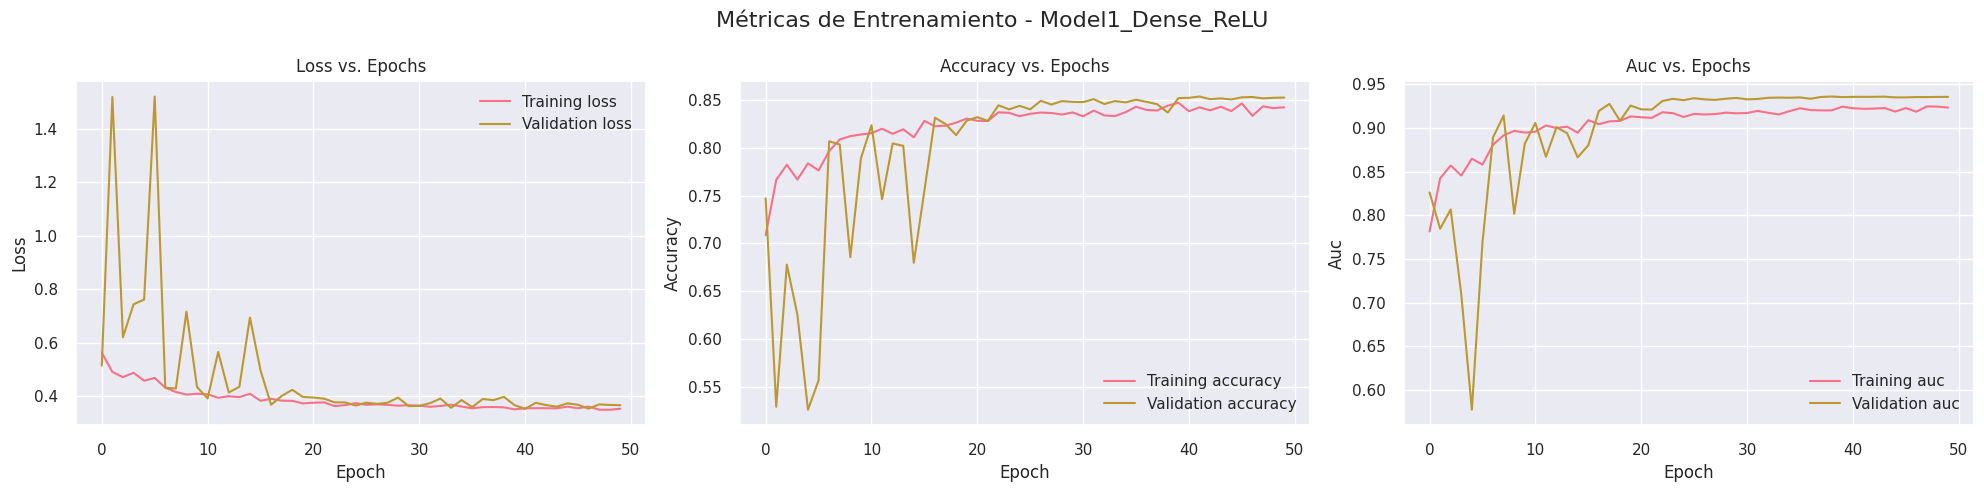

112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - accuracy: 0.8249 - auc: 0.4777 - loss: 0.3922
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step


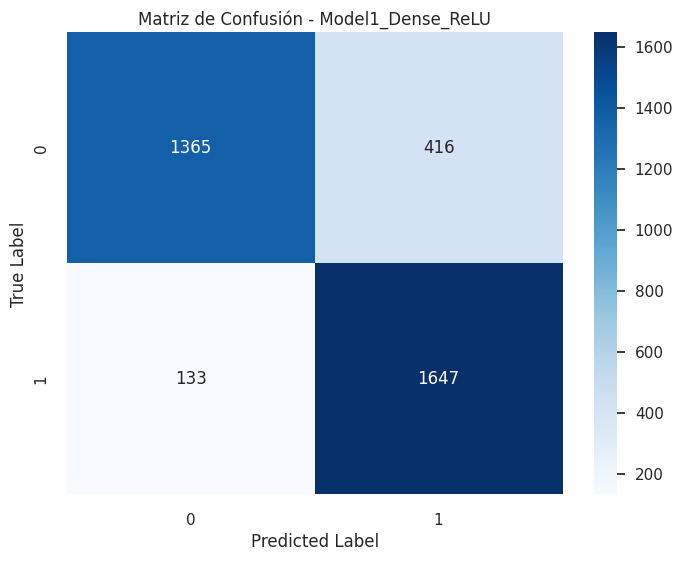

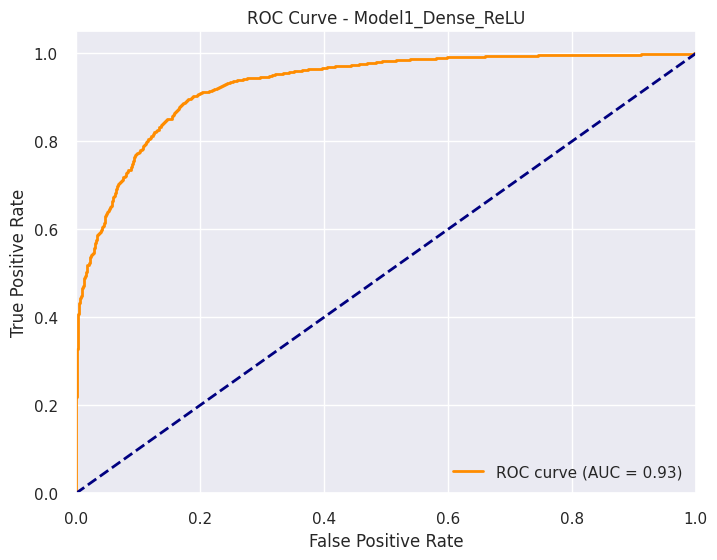


📊 Reporte de Clasificación - Model1_Dense_ReLU:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      1781
           1       0.80      0.93      0.86      1780

    accuracy                           0.85      3561
   macro avg       0.85      0.85      0.84      3561
weighted avg       0.85      0.85      0.84      3561


🚀 Entrenando Model2_CNN_LeakyReLU...

🏗️ Arquitectura del modelo Model2_CNN_LeakyReLU:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │      11,075,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,132,033 (42.47 MB)

 Trainable params: 11,132,033 (42.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 109s 295ms/step - accuracy: 0.6248 - auc: 0.6594 - loss: 0.8591 - val_accuracy: 0.6701 - val_auc: 0.7748 - val_loss: 0.5689 - learning_rate: 0.0010
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 84s 249ms/step - accuracy: 0.6961 - auc: 0.7623 - loss: 0.5530 - val_accuracy: 0.6300 - val_auc: 0.7097 - val_loss: 0.6871 - learning_rate: 0.0010
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 86s 254ms/step - accuracy: 0.7271 - auc: 0.8093 - loss: 0.5218 - val_accuracy: 0.7819 - val_auc: 0.8789 - val_loss: 0.4411 - learning_rate: 0.0010
Epoch 4/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 86s 252ms/step - accuracy: 0.7815 - auc: 0.8664 - loss: 0.4521 - val_accuracy: 0.8116 - val_auc: 0.9138 - val_loss: 0.4045 - learning_rate: 0.0010
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 85s 250ms/step - accuracy: 0.8168 - auc: 0.8948 - loss: 0.4105 - val_accuracy: 0.7810 - val_auc: 0.9192 - val_loss: 0.4408 - learning_rate: 0.0010
Epoch 6/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 142s 249ms/step - accura

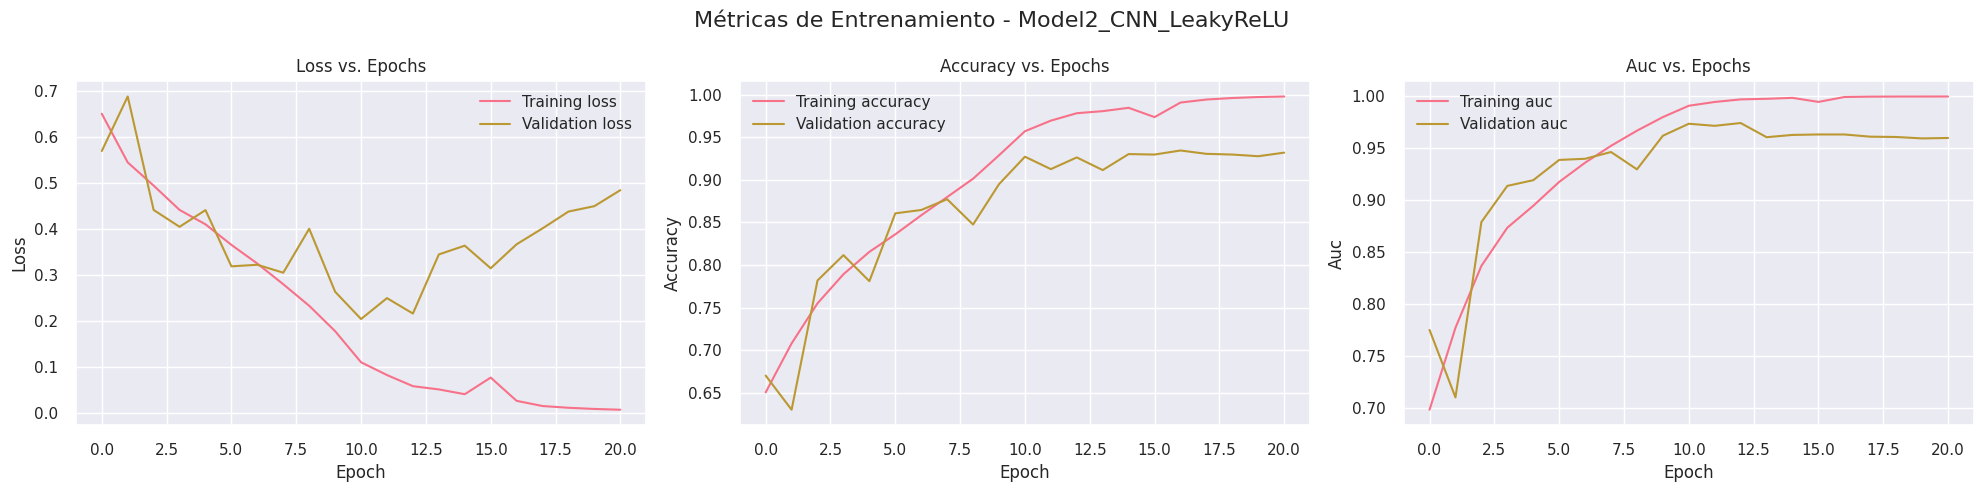

112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - accuracy: 0.9542 - auc: 0.5005 - loss: 0.1285
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step


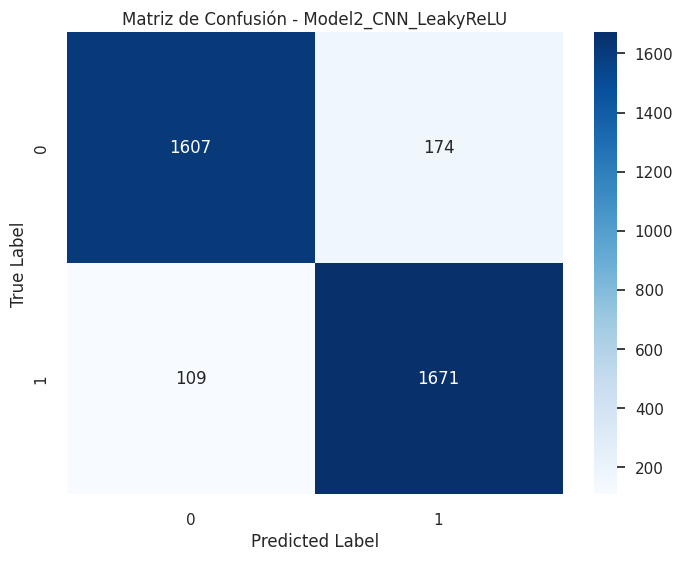

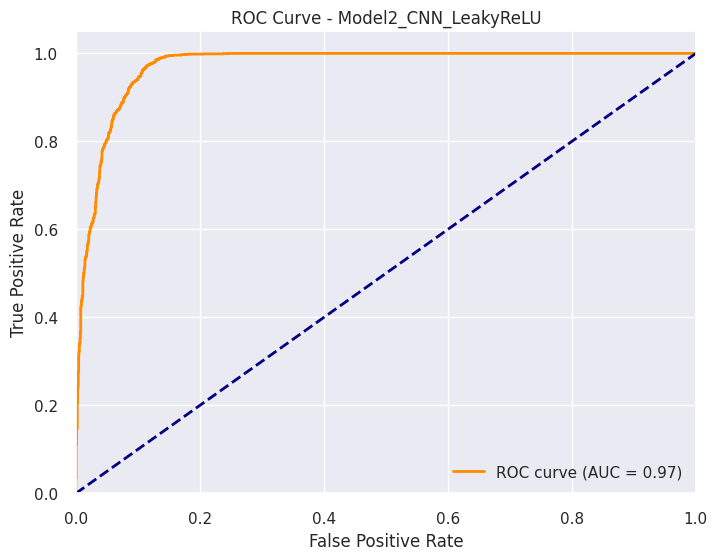


📊 Reporte de Clasificación - Model2_CNN_LeakyReLU:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1781
           1       0.91      0.94      0.92      1780

    accuracy                           0.92      3561
   macro avg       0.92      0.92      0.92      3561
weighted avg       0.92      0.92      0.92      3561


🚀 Entrenando Model3_DeepCNN_ReLU...

🏗️ Arquitectura del modelo Model3_DeepCNN_ReLU:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,178,945 (42.64 MB)

 Trainable params: 11,178,113 (42.64 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 114s 309ms/step - accuracy: 0.8293 - auc: 0.8969 - loss: 0.4036 - val_accuracy: 0.5918 - val_auc: 0.6654 - val_loss: 3.1276 - learning_rate: 0.0010
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 89s 263ms/step - accuracy: 0.9063 - auc: 0.9610 - loss: 0.2368 - val_accuracy: 0.4997 - val_auc: 0.5059 - val_loss: 14.5831 - learning_rate: 0.0010
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 88s 259ms/step - accuracy: 0.9233 - auc: 0.9696 - loss: 0.2019 - val_accuracy: 0.5856 - val_auc: 0.6989 - val_loss: 0.7146 - learning_rate: 0.0010
Epoch 4/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 143s 262ms/step - accuracy: 0.9238 - auc: 0.9728 - loss: 0.1925 - val_accuracy: 0.8501 - val_auc: 0.9692 - val_loss: 0.3450 - learning_rate: 0.0010
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 142s 264ms/step - accuracy: 0.9265 - auc: 0.9739 - loss: 0.1863 - val_accuracy: 0.8290 - val_auc: 0.9514 - val_loss: 0.4623 - learning_rate: 0.0010
Epoch 6/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 142s 265ms/step - acc

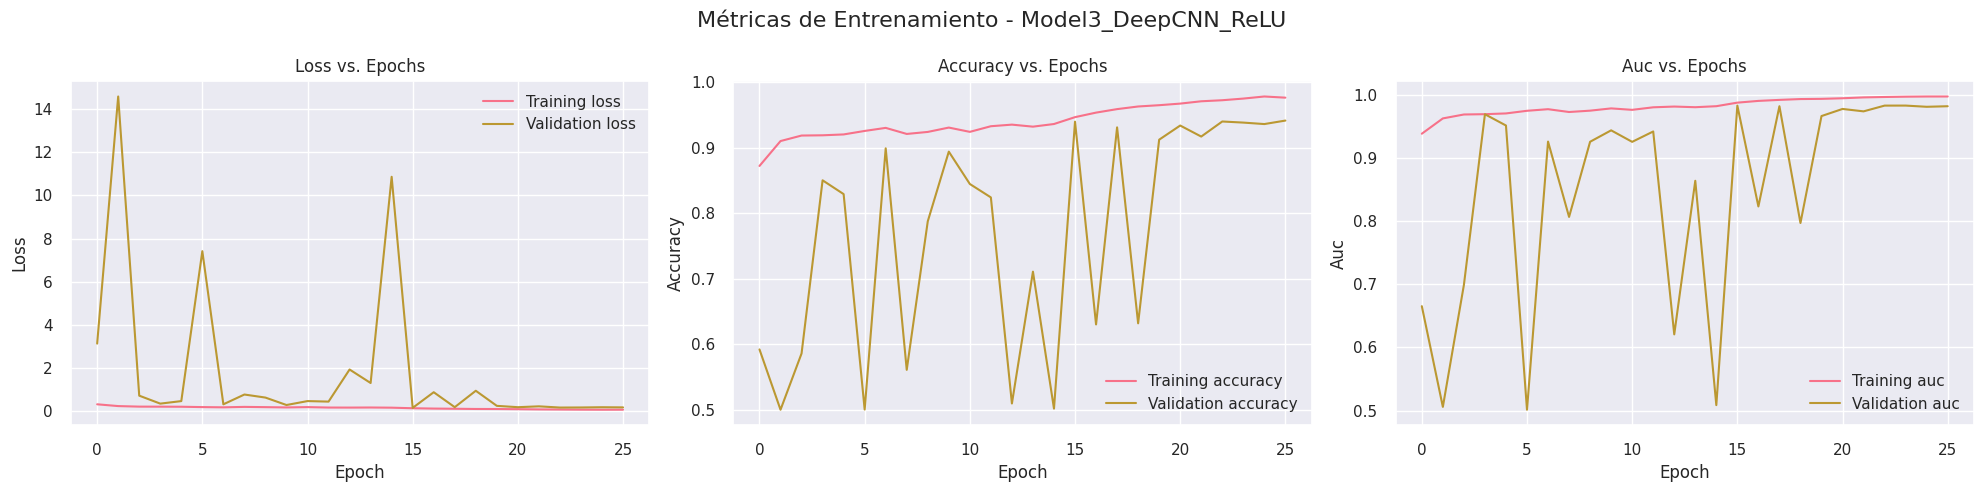

112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - accuracy: 0.9532 - auc: 0.5049 - loss: 0.1042
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step


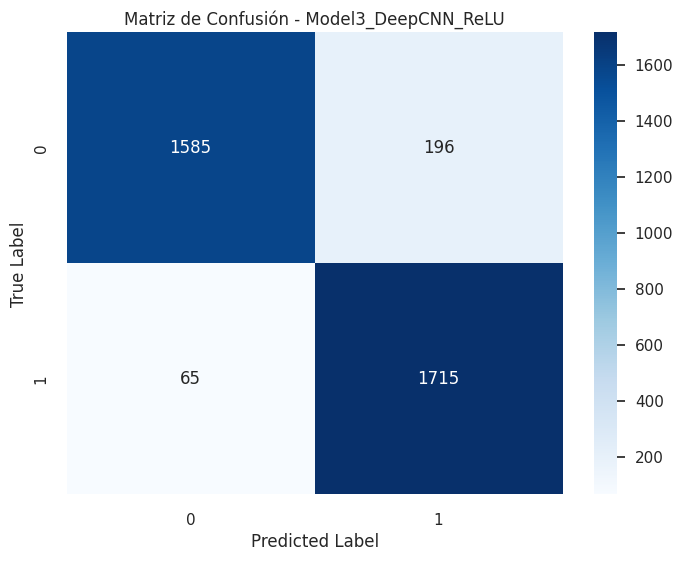

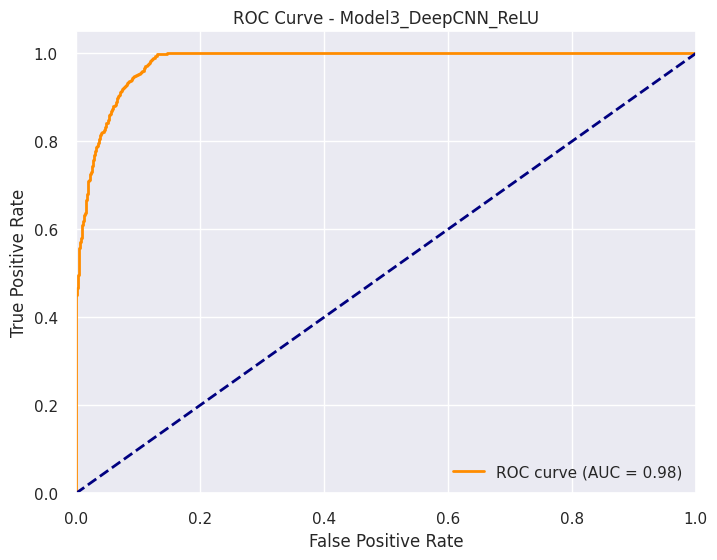


📊 Reporte de Clasificación - Model3_DeepCNN_ReLU:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1781
           1       0.90      0.96      0.93      1780

    accuracy                           0.93      3561
   macro avg       0.93      0.93      0.93      3561
weighted avg       0.93      0.93      0.93      3561


🏆 Mejor modelo: Model3_DeepCNN_ReLU
Test Accuracy: 0.9267
Test AUC: 0.9796


In [19]:
# Ejecución principal
if __name__ == "__main__":
    print("🎯 Iniciando experimentos de clasificación de melanoma...")

    # Configurar el dataset
    base_dir = setup_dataset()

    # Ejecutar experimentos
    results = run_experiments(base_dir)

    # Encontrar el mejor modelo
    best_model_name = max(results.keys(),
                         key=lambda x: results[x]['test_auc'])

    print(f"\n🏆 Mejor modelo: {best_model_name}")
    print(f"Test Accuracy: {results[best_model_name]['test_accuracy']:.4f}")
    print(f"Test AUC: {results[best_model_name]['test_auc']:.4f}")